Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menu bar, select Cell$\rightarrow$Run All).

Below, please fill in your name and collaborators:

# <font color=#283593> Group 5 Assignment - Predict Future Sales </font>


In [1]:
NAME = "Group 5"
COLLABORATORS = "Adejobi, Temidayo ; Koffi, Beniamkem ; Luo, Haiming ; Parra, Karen ;Vaithianathan, Elanchezhian"

## <font color=#283593>Assignment tasks</font>

Group assignment objectivie is to showcase what is learned in the course. Group shall able to choose which type of analysis they would like to complete from the options below.

Choose one of the following for your project:

1. Make a hypothesis about a correlation in a dataset and test the hypothesis using a statistical inference technique (such as the t-test).
2. Build a predictive model using one of the techniques covered in the course, i.e., ordinary least squares regression or Naïve Bayes.

<font color = #283593>The dataset chosen on which the analysis is "Predict Future Sales" dataset.</font>    

The dataset was downloaded from the public dataset on Kaggle at the url, https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

The dataset is being used under the terms of the licence below.

License: This work is licensed under the Creative Commons Attribution 3.0 Unported License. To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/.

# <font color=#283593>1. Data preparation</font>


In [2]:
## 1.1 Loading the dataset# import libs
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.tools.eval_measures import rmse
from pmdarima.arima import auto_arima
from sklearn import tree

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
# from googletrans import Translator
#from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix

Brief note of the dataset is provided below. Predict future sales dataset cons assignment objectivie is to showcase what is learned in the course. Group shall able to choose which type of analysis they would like to complete from the options below.

Choose one of the following for your project:

1. sales_train_v2.csv - Main dataset that provides the sales data per month and would be use to train the model.
2. shops.csv - Shop id to shop name
3. item_categories.csv - Item category id to Item category name
4. items.csv - Item id to Item name.
5. test.csv - dataset that would be used to test the model.

## <font color='#283593'>1.1 Loading the dataset</font>


In [3]:
# Read dataset file that was donwloaded
#sales_dirty_df = pd.read_csv(filepath_or_buffer='sales_train_v2.csv', sep=',')
sales_train_df = pd.read_csv('sales_train_v2.csv', sep=',',header=0)
shops_df = pd.read_csv('shops.csv', sep=',',header=0)
item_category_df = pd.read_csv('item_categories.csv', sep=',',header=0)
items_df = pd.read_csv('items.csv', sep=',',header=0)
test_df = pd.read_csv('test.csv', sep=',',header=0)


## <font color='#283593'>1.2 Analyse the dataset 'sales_train_v2.csv'</font>

### <font color='#283593'>1.2.1 Basic inspection of the original dataset</font>

In [4]:
# View info()
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
sales_train_df.dropna(inplace=True)

In [6]:
# view tail of data# view head 
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
# view tail of data
sales_train_df.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


### <font color='#283593'>1.2.2 Basic inspection of the supporting dataset</font>

In [8]:
# Analyzing items dataset
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [9]:
# Analyzing Shops dataset
shops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [10]:
# Analyzing Items category dataset
item_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [11]:
# Analyzing test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


### <font color='#283593'>1.3 Data cleansing and transformation</font>

In [12]:
# Split the date into day, month and year to facilitate deeper interpretation.

raw_date = sales_train_df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

sales_train_df['day'] = raw_date.dt.day
sales_train_df['month'] = raw_date.dt.month
sales_train_df['year'] = raw_date.dt.year

sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,2,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,3,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,5,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,6,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,15,1,2013


In [13]:
# calculate the sales store per month
sales_train_df['sales']=sales_train_df.item_price*sales_train_df.item_cnt_day

In [14]:
# Add item category to the sales train dataset
sales_train_df = pd.merge(sales_train_df,items_df, on='item_id')
sales_train_df.drop('item_name', axis=1,inplace=True)

In [15]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,sales,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,2,1,2013,999.0,37
1,23.01.2013,0,24,22154,999.0,1.0,23,1,2013,999.0,37
2,20.01.2013,0,27,22154,999.0,1.0,20,1,2013,999.0,37
3,02.01.2013,0,25,22154,999.0,1.0,2,1,2013,999.0,37
4,03.01.2013,0,25,22154,999.0,1.0,3,1,2013,999.0,37


# <font color='#283593'>2. Feature Analysis </font>

### <font color='#283593'>2.1 Seasonality Summary</font>

In [16]:
sales_train_df['sales'].describe()

count    2.935849e+06
mean     1.157732e+03
std      5.683604e+03
min     -6.897000e+04
25%      2.490000e+02
50%      4.490000e+02
75%      1.078200e+03
max      1.829990e+06
Name: sales, dtype: float64

year
2013    1.217525e+09
2014    1.346778e+09
2015    8.346231e+08
Name: sales, dtype: float64

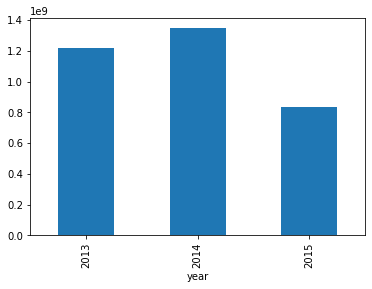

In [17]:
#Sales Group by Year
Sales_by_year = sales_train_df.groupby('year')['sales'].sum()
display(Sales_by_year)
Sales_by_year.plot.bar()

Text(0.5, 1.0, 'Sales by Year')

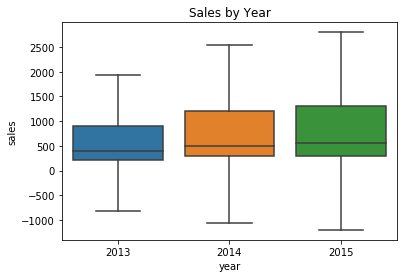

In [18]:
sns.boxplot(x="year", y="sales", data=sales_train_df, showfliers=False).set_title('Sales by Year')

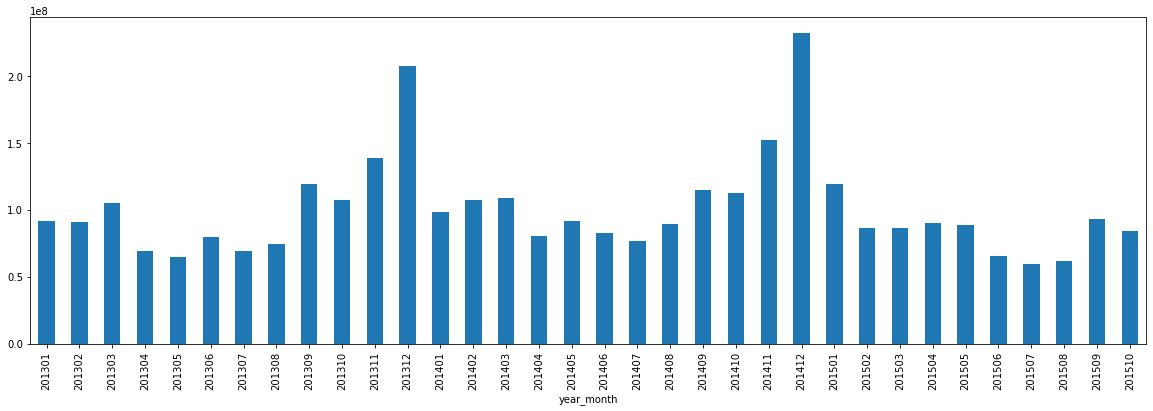

In [19]:
#Sales Group by Year and Month
sales_train_df['year_month'] =sales_train_df['year']*100 + sales_train_df['month']
Sales_by_Month = sales_train_df.groupby('year_month')['sales'].sum()
Sales_by_Month.plot.bar(figsize=(20, 6), subplots=False)

Text(0.5, 1.0, 'Sales by Year and Month')

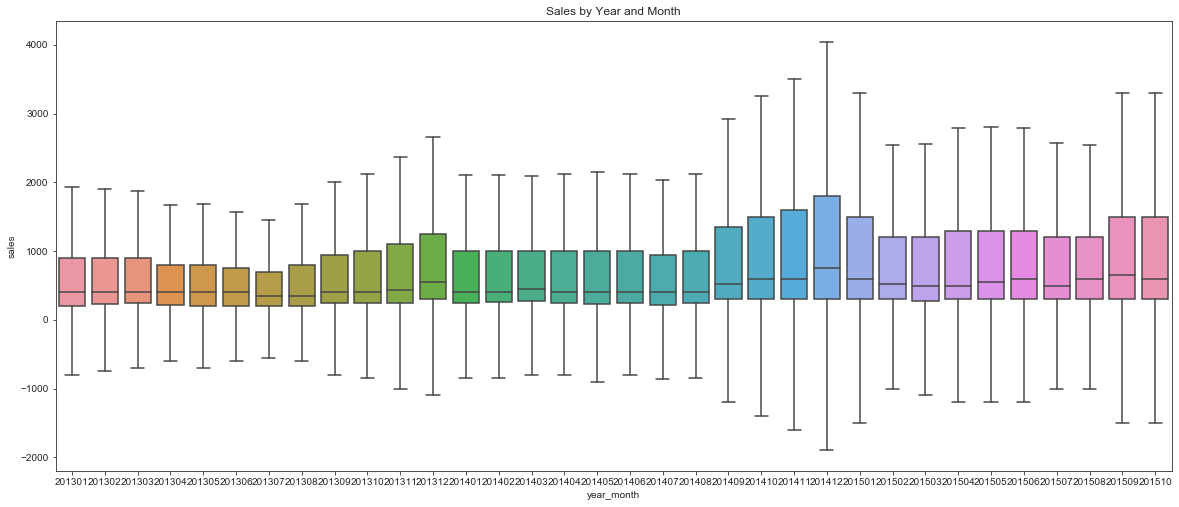

In [20]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8.27)
sns.boxplot(x="year_month", y="sales", data=sales_train_df, showfliers=False).set_title('Sales by Year and Month')

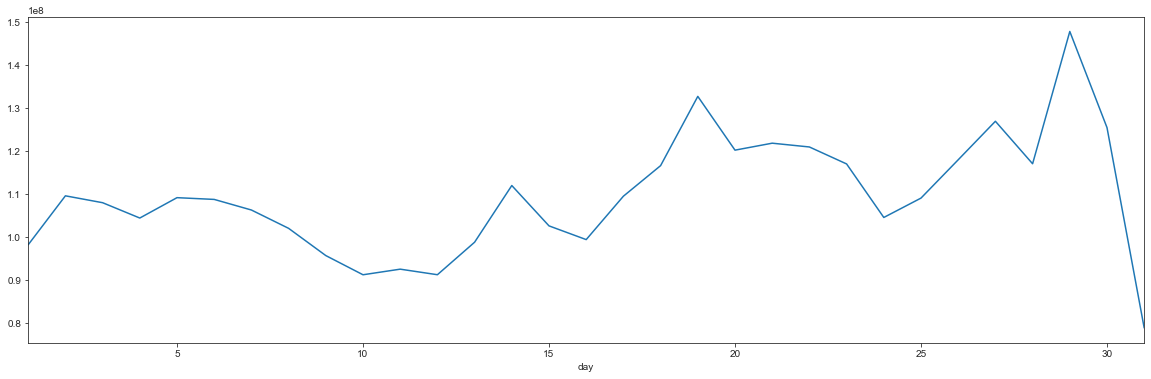

In [21]:
#Sales Group by day 
Sales_by_day = sales_train_df.groupby('day')['sales'].sum()
Sales_by_day.plot.line(figsize=(20, 6), subplots=False)

Text(0.5, 1.0, 'Sales by day')

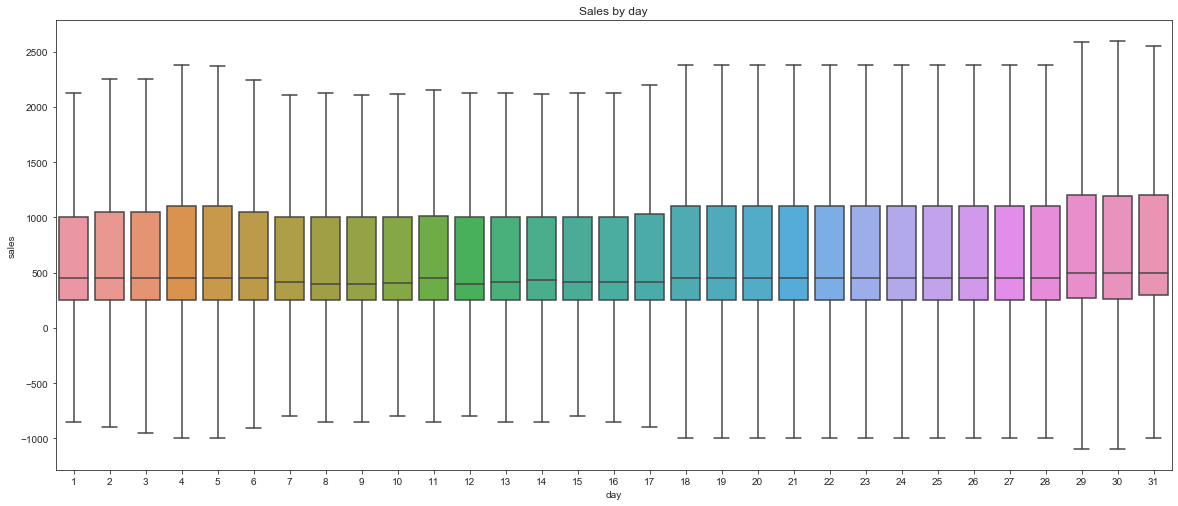

In [22]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8.27)
sns.boxplot(x="day", y="sales", data=sales_train_df, showfliers=False).set_title('Sales by day')

### <font color='#283593'>2.2 Sales and Volume Distribution by Shop</font>

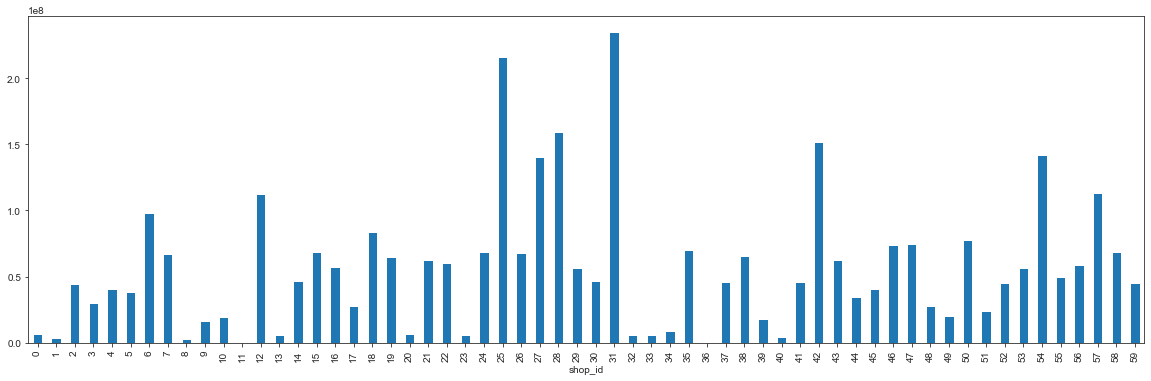

In [23]:
#Sales Group by Shop ID 
Sales_by_Shop = sales_train_df.groupby('shop_id')['sales'].sum()
Sales_by_Shop.plot.bar(figsize=(20, 6), subplots=False)

Text(0.5, 1.0, 'Sales by shop_id')

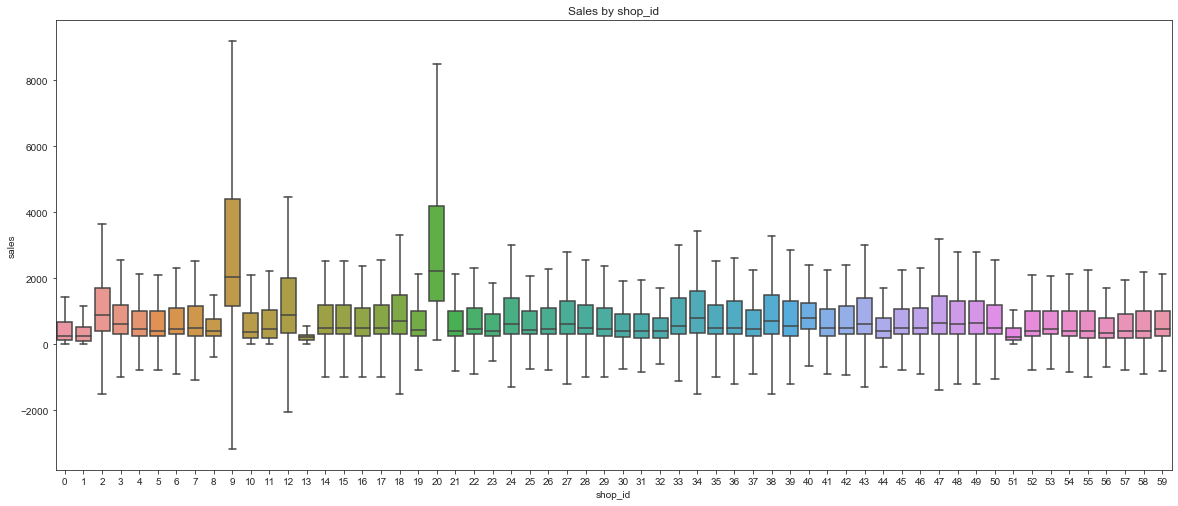

In [24]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8.27)
sns.boxplot(x="shop_id", y="sales", data=sales_train_df, showfliers=False).set_title('Sales by shop_id')

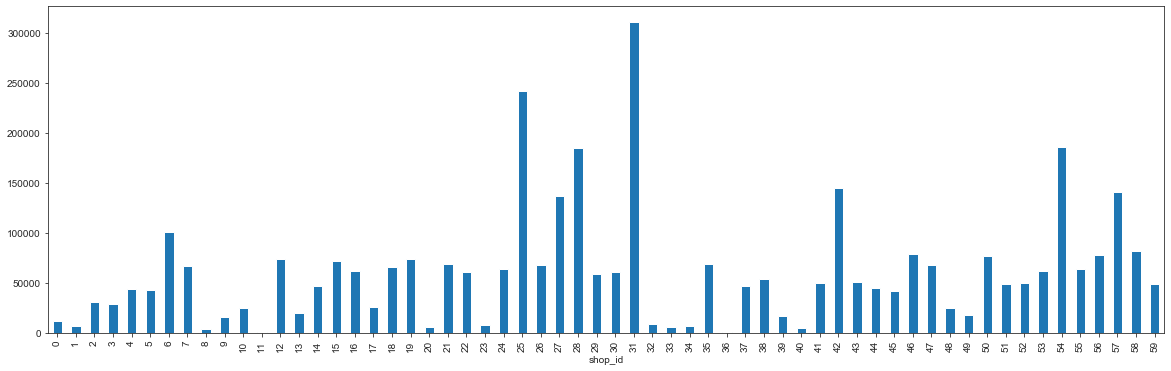

In [25]:
#Volume Group by Shop ID 
Volume_by_Shop = sales_train_df.groupby('shop_id')['item_cnt_day'].sum()
Volume_by_Shop.plot.bar(figsize=(20, 6), subplots=False)

### <font color='#283593'>2.3 Sales and Volume Distribution by item category</font>

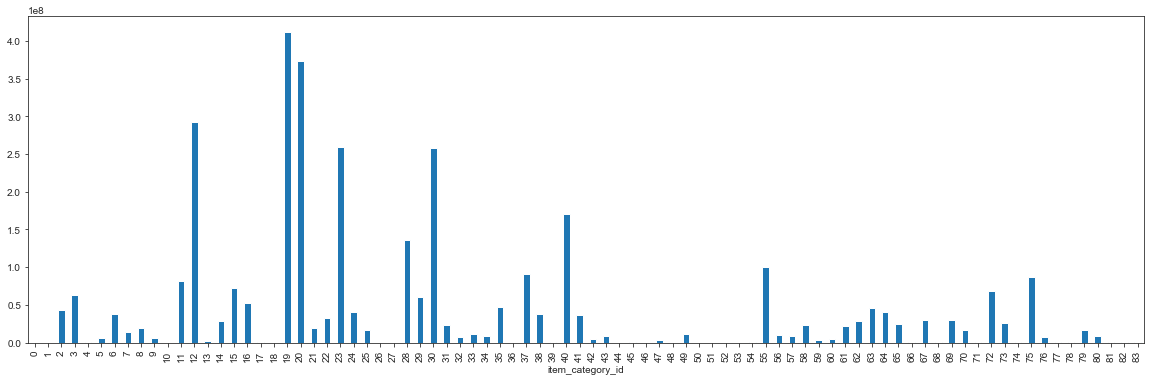

In [26]:
#Sales Group by item_category_id  
Sales_by_item_category = sales_train_df.groupby('item_category_id')['sales'].sum()
Sales_by_item_category.plot.bar(figsize=(20, 6), subplots=False)

Text(0.5, 1.0, 'Sales by item_category')

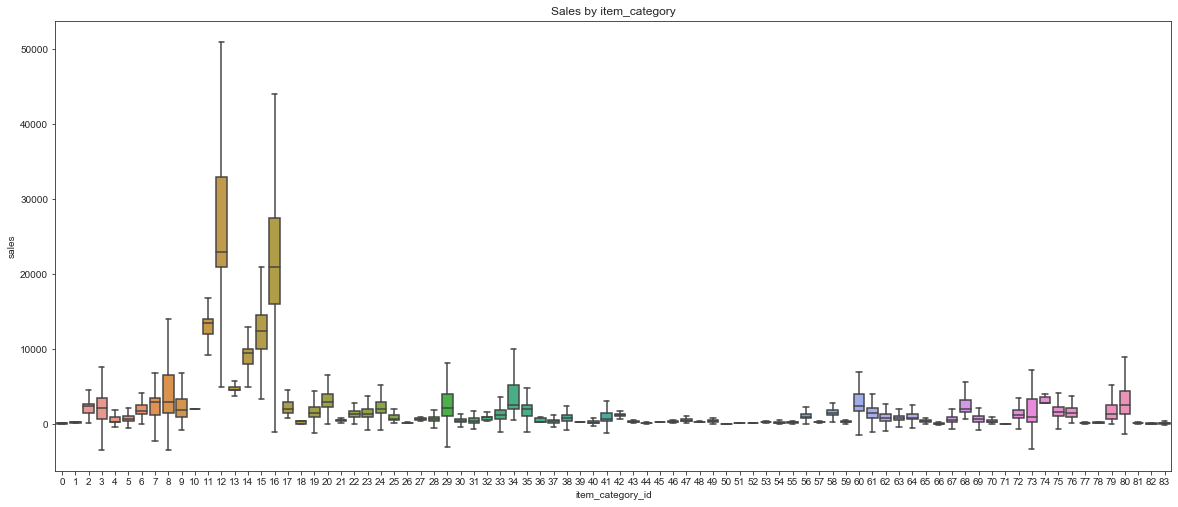

In [27]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8.27)
sns.boxplot(x="item_category_id", y="sales", data=sales_train_df, showfliers=False).set_title('Sales by item_category')

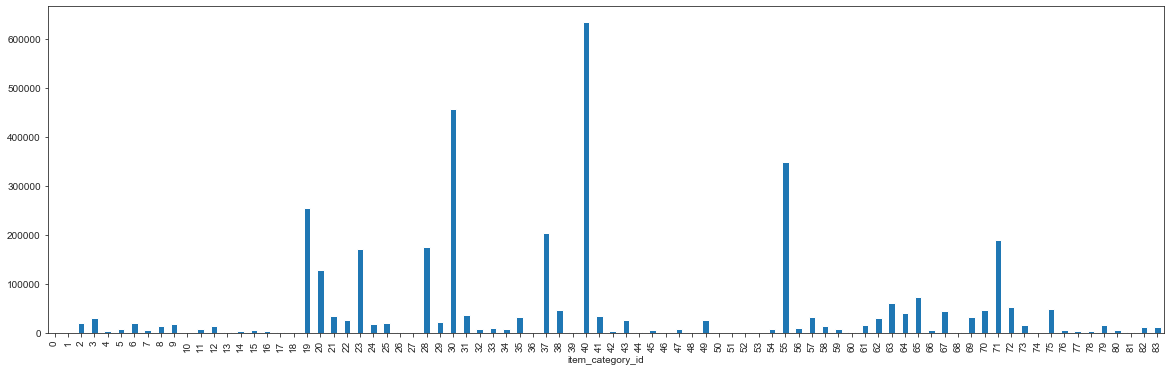

In [28]:
#Volume Group by item_category_id 
Volume_by_item_category = sales_train_df.groupby('item_category_id')['item_cnt_day'].sum()
Volume_by_item_category.plot.bar(figsize=(20, 6), subplots=False)

### <font color='#283593'>2.4 Shops and Item Variety</font>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000281835617F0>],
      dtype=object)

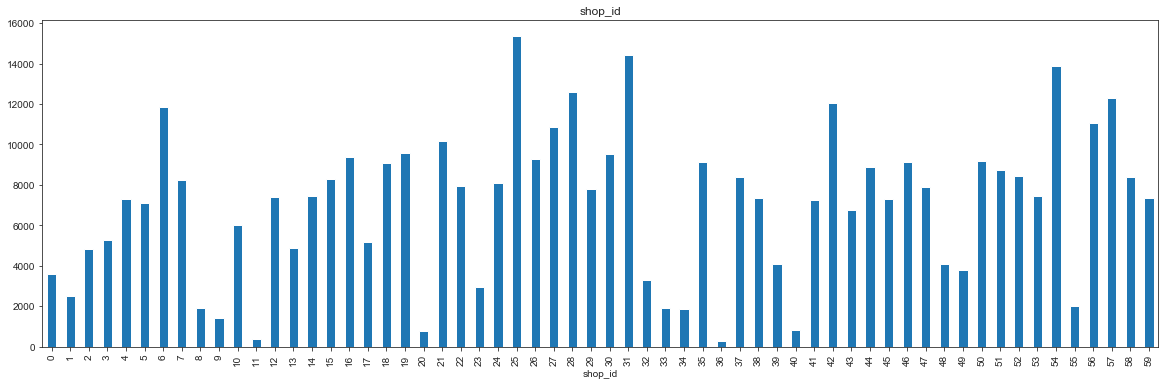

In [29]:
#check each shop's number of unque item ID 
shop_by_item_variety = sales_train_df[['shop_id','item_id']].drop_duplicates()
shop_by_item_variety_count = shop_by_item_variety.groupby('shop_id')['shop_id'].count()
shop_by_item_variety_count.plot.bar(figsize=(20, 6), subplots=True)

<Figure size 432x288 with 0 Axes>

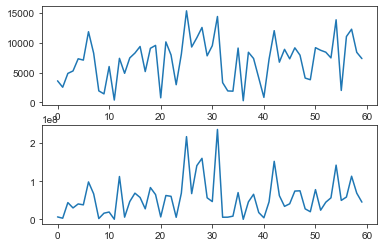

In [30]:
#check if the shops with more unique item number has more sales
plt.figure()
f, axes = plt.subplots(2, 1)
axes[0].plot(shop_by_item_variety_count)
axes[1].plot(Sales_by_Shop)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028184FEA9B0>],
      dtype=object)

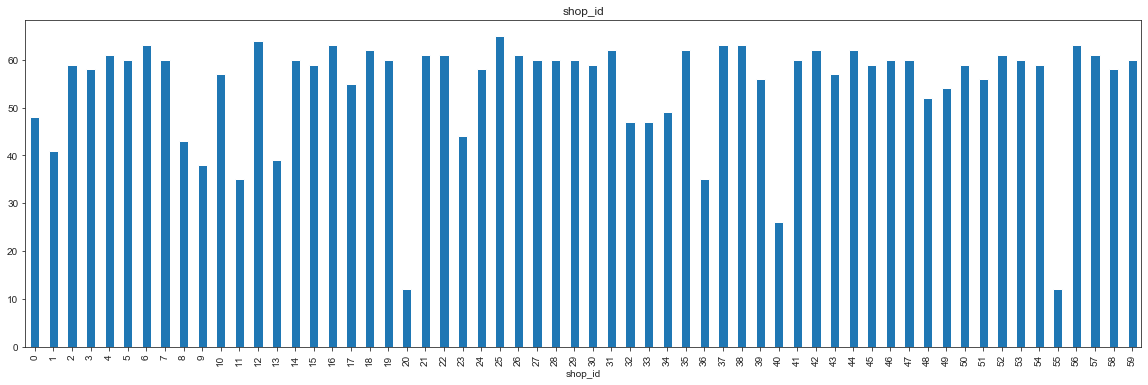

In [31]:
#check each shop's number of item category 
shop_by_item_cat = sales_train_df[['shop_id','item_category_id']].drop_duplicates()
shop_by_item_cat_count = shop_by_item_cat.groupby('shop_id')['shop_id'].count()
shop_by_item_cat_count.plot.bar(figsize=(20, 6), subplots=True)

<Figure size 432x288 with 0 Axes>

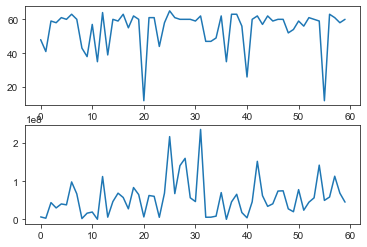

In [32]:
#check if the shops with more unique item category has more sales
plt.figure()
f, axes = plt.subplots(2, 1)
axes[0].plot(shop_by_item_cat_count)
axes[1].plot(Sales_by_Shop)


### <font color='#283593'>2.5 Scatter Matrix</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028185187F28>,
      dtype=object)

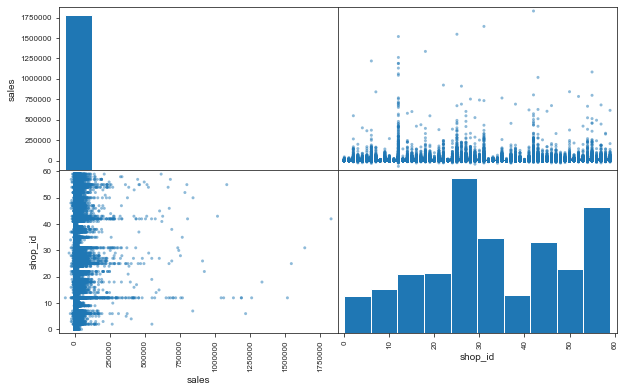

In [33]:
scatter_matrix(sales_train_df[['sales','shop_id']],figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028185AE08D0>,
      dtype=object)

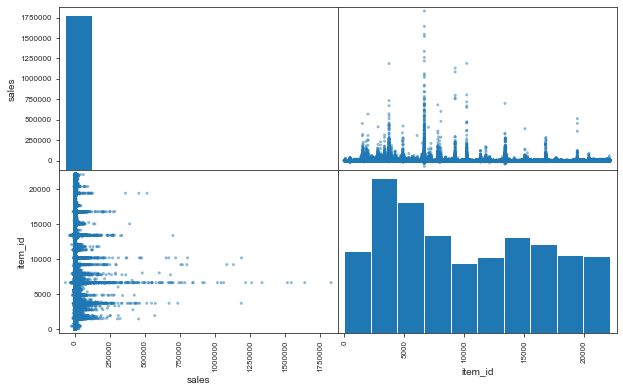

In [34]:
scatter_matrix(sales_train_df[['sales','item_id']],figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028185ACC278>,
      dtype=object)

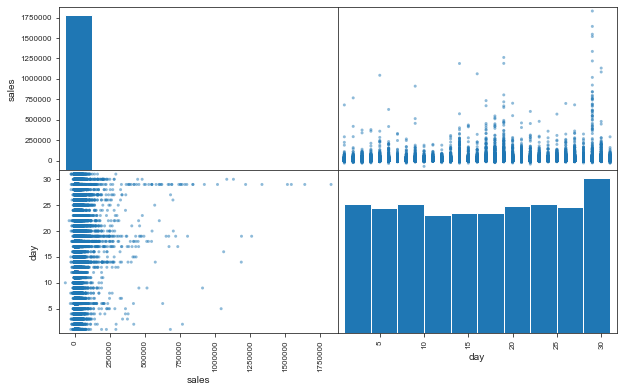

In [35]:
scatter_matrix(sales_train_df[['sales','day']],figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281878E9278>,
      dtype=object)

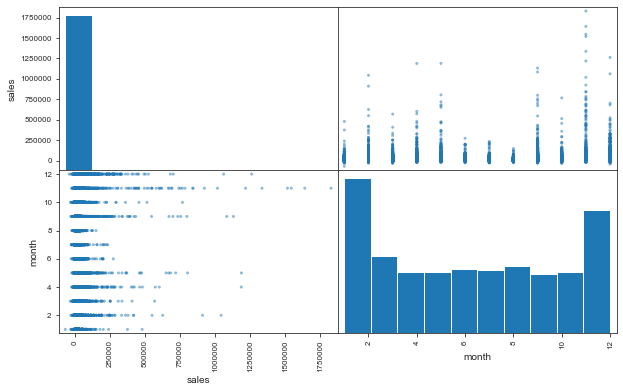

In [36]:
scatter_matrix(sales_train_df[['sales','month']],figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028184835438>,
      dtype=object)

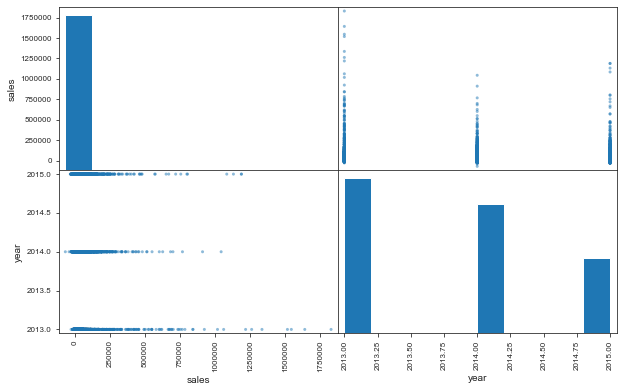

In [37]:
scatter_matrix(sales_train_df[['sales','year']],figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281875C1E80>,
      dtype=object)

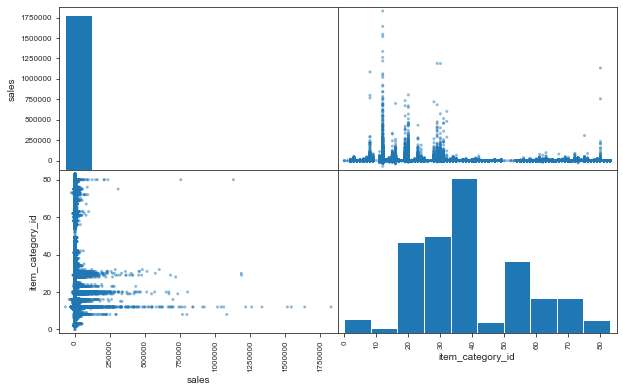

In [38]:
scatter_matrix(sales_train_df[['sales','item_category_id']],figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281863F2B70>,
      dtype=object)

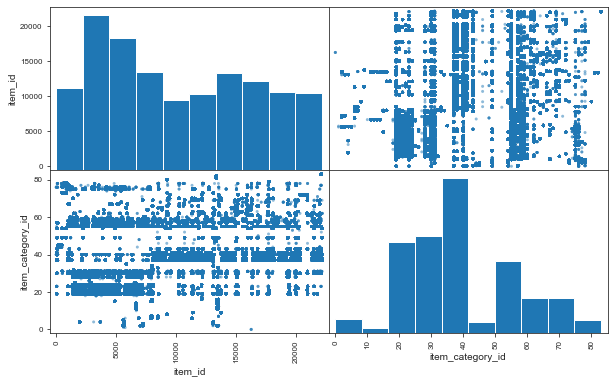

In [39]:
scatter_matrix(sales_train_df[['item_id','item_category_id']],figsize=(10, 6))

## <font color='#283593'>3. Modelling</font>

### <font color='#283593'>3.1 Conditions over test and training set</font>

In [40]:
#Cleaning items that appear in test set but do not appear in train set (no information about items)

test_df['shop_item']=test_df['shop_id'].astype(str)+'-'+test_df['item_id'].astype(str)
test_items=test_df['shop_item'].unique()
sales_train_df['shop_item']=sales_train_df['shop_id'].astype(str)+'-'+sales_train_df['item_id'].astype(str)
train_items=pd.DataFrame(sales_train_df['shop_item'].unique())
train_items.columns=['shop_item']

test_df2=pd.merge(test_df,train_items,on=['shop_item'])     #-- Must appear the items of test in train set


In [41]:
print('test_df',test_df.shape)  
print('test_df2',test_df2.shape)

test_df (214200, 4)
test_df2 (111404, 4)


In [42]:
sales_train_df2=pd.merge(sales_train_df,test_df2['shop_item'],on=['shop_item'])

In [43]:
print('sales_train_df',sales_train_df.shape) 
print('sales_train_df2',sales_train_df2.shape)

sales_train_df (2935849, 13)
sales_train_df2 (1224439, 13)


In [44]:
#The feature 'item_cnt_day' by definition is the number of products sold. So, it'll be cleaned those cases where the values are <0

sales_train_df2['item_id'][sales_train_df2['item_cnt_day']<0].count()

2941

In [45]:
sales_train_df2=sales_train_df2[sales_train_df2['item_cnt_day']>=0]
print('sales_train_df2',sales_train_df2.shape)
print('max item_cnt_day',max(sales_train_df2['item_cnt_day']))
print('min item_cnt_day',min(sales_train_df2['item_cnt_day']))

sales_train_df2 (1221498, 13)
max item_cnt_day 2169.0
min item_cnt_day 1.0


In [46]:
#----- Outdate items (No sold item in the past 7 months) 

sales_by_item_id = sales_train_df2.pivot_table(index=['item_id'],values=['item_cnt_day'],columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns
sales_by_item_id.columns=sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id2=sales_by_item_id.reset_index(drop=True).rename_axis(None,axis=1)
sales_by_item_id2.columns
sales_by_item_id2.columns.values[0]='item_id'
sales_by_item_id2.head()

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,30,0,600,394,105,45,46,30,16,12,...,12,13,4,4,5,4,4,6,2,1
1,31,0,466,155,45,25,21,13,20,18,...,22,11,10,13,4,10,6,52,9,18
2,32,225,156,143,80,53,65,79,65,45,...,36,25,34,19,19,25,21,30,19,22
3,33,42,30,26,13,11,40,38,29,37,...,17,21,20,12,11,11,15,14,17,16
4,38,0,0,0,0,0,0,0,0,0,...,4,4,1,0,3,2,4,7,3,0


In [47]:
sales_by_item_id3=sales_by_item_id2[sales_by_item_id2.loc[:,'27':].sum(axis=1)==0]

In [48]:
sales_train_df3=sales_train_df2[~(sales_train_df2['item_id'].isin(sales_by_item_id3['item_id']))]

sales_train_df3.shape   #--- Excluding no items sold in the past 7 months

(1212159, 13)

In [49]:
test_item_out=test_df[test_df['item_id'].isin(sales_by_item_id3['item_id'])]

test_df3=test_df2[~(test_df2['item_id'].isin(sales_by_item_id3['item_id']))]

print('test_df',test_df2.shape)  
print('test_df2',test_df3.shape) # Excluding no items sold in the past 7 months

test_df (111404, 4)
test_df2 (109191, 4)


In [50]:
#----- Training grouped by month

sales_train_df4=sales_train_df3.groupby(['shop_id','month','year']).sum()

sales_train_df5=sales_train_df4.add_suffix('_total').reset_index()

sales_train_df5=sales_train_df5.sort_values(by=['year','month'])

sales_train_df5['month_year']=sales_train_df5['month'].astype(str)+'-'+sales_train_df5['year'].astype(str)

vec_date=sales_train_df5['month_year'].unique()

vec_date=pd.DataFrame(vec_date)

vec_date['uniq_date']=vec_date.index.get_values()+1

vec_date.columns=['month_year','uniq_date']

sales_train_df6=pd.merge(sales_train_df5,vec_date,on='month_year')

In [51]:
#Exclude fom the study those shops that don't have at least 4 months of history

sales_train_df6b=sales_train_df6[['shop_id','month','year','month_year']].groupby(['shop_id']).count()
sales_train_df6b=sales_train_df6b[sales_train_df6b['month_year']<4].reset_index()
sales_train_df7=sales_train_df6[~(sales_train_df6['shop_id'].isin(sales_train_df6b['shop_id']))] 

sales_train_df7=sales_train_df7.drop(['item_id_total','item_price_total','day_total'],axis=1)

print('sales_train_df6',sales_train_df6.shape) 
print('sales_train_df7',sales_train_df7.shape) 

sales_train_df6 (1327, 13)
sales_train_df7 (1326, 10)


In [52]:
sales_train_df7.head()

,shop_id,month,year,date_block_num_total,item_cnt_day_total,sales_total,item_category_id_total,year_month_total,month_year,uniq_date
0,2,1,2013,0,250.0,220780.99,8888,45896628,1-2013,1
1,3,1,2013,0,179.0,133162.50,6372,35026374,1-2013,1
2,4,1,2013,0,443.0,319247.61,14845,78909992,1-2013,1
3,6,1,2013,0,809.0,605058.90,27807,135676874,1-2013,1
4,7,1,2013,0,529.0,397997.91,18405,95416674,1-2013,1


In [53]:
#----- Test grouped by month

test_df4=test_df3.groupby('shop_id').count()

test_df4['uniq_date']=35

test_df5=test_df4.reset_index()

In [98]:
# Excluding shops without at least 4 months of history

test_df6=test_df5[~(test_df5['shop_id'].isin(sales_train_df6b['shop_id']))] 
test_df6.shape

(41, 5)

### <font color='#283593'>3.2.1 Regression Tree</font>

In [55]:
X=sales_train_df7[['shop_id','uniq_date']]
y=np.array(sales_train_df7['item_cnt_day_total'])
x1=test_df6[['shop_id','uniq_date']]

tree_sales = tree.DecisionTreeRegressor(max_depth=30,min_samples_split=2)
tree_sales = tree_sales.fit(X,y)
tree_sales = tree_sales.predict(x1)

print('tree_sales',len(tree_sales)) 
print('test_df6[shop_id]',len(test_df6['shop_id'])) 

tree_sales 41
test_df6[shop_id] 41


### <font color='#283593'>3.2.2 ARIMA Implementation</font>

In [56]:

pred_final={}

for i in test_df6['shop_id'].unique():
    model=auto_arima(np.array(sales_train_df7['item_cnt_day_total'][sales_train_df7['shop_id']==i]), error_action='ignore', suppress_warnings=True)
    model.fit(np.array(sales_train_df7['item_cnt_day_total'][sales_train_df7['shop_id']==i]))
    pred=model.predict(n_periods=1)
    pred_final[i]=pred

print('arima_pred',len(pred_final.keys()))     
print('test_df6[shop_id]',len(test_df6['shop_id'])) 

arima_pred 41
test_df6[shop_id] 41


## <font color='#283593'>4. Models Performance</font>

In [57]:
def mae(real,pred):
    result=np.mean(abs((real-pred)))
    return result    

RMSE_Tree=np.sqrt(mae(test_df6['shop_id'],tree_sales))

real=test_df6[['shop_id','item_id']][test_df6['shop_id'].isin(list(pred_final.keys()))]

rmse_vec=[]

for k in pred_final.keys():
    rmse_vec.append(np.sqrt(mae(real['item_id'][real['shop_id']==k],pred_final[k])))
    
RMSE_Arima=np.mean(rmse_vec)    

print('RMSE_Tree',RMSE_Tree)
print('RMSE_Arima',RMSE_Arima)

RMSE_Tree 38.68131205684502
RMSE_Arima 37.248914660281365


# additional to model performance


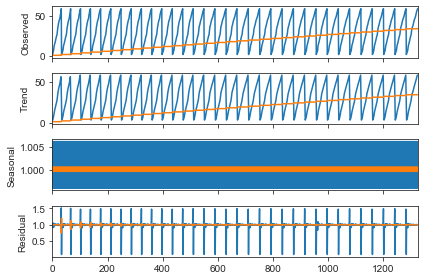

In [175]:
#let check our Model residual error
# plot residual errors
from statsmodels.tsa.seasonal import seasonal_decompose
series = sales_train_df7[['shop_id','uniq_date']]
result = seasonal_decompose(series, model='multiplicative', freq=3)
result.plot()
pyplot.show()


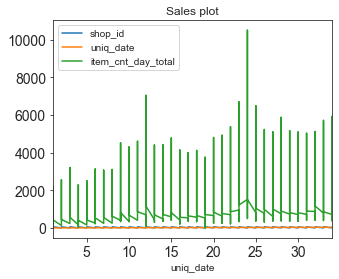

In [226]:

test_df7=sales_train_df7[['shop_id','uniq_date','item_cnt_day_total']]

test_df7.index = test_df7.uniq_date
test_df7.plot(figsize=(5,4), title= 'Sales plot', fontsize=14)
plt.show()
# observation: we can see that the sales is steady throughout the year but has some peaks before January, july

In [103]:
#the graph confirms a trend

# observation:  the items_day-cont total seems to have some a stationarity  while the rest of the column are constant 
test_df7.head(3)

,shop_id,uniq_date,item_cnt_day_total
0,2,1,250.0
1,3,1,179.0
2,4,1,443.0


In [141]:
# Check for other odd value due to dicky fuller NAN values 
#missing value treatment
test_df7.fillna(0)

test_df7.head(3)



,shop_id,uniq_date,item_cnt_day_total
uniq_date,,,
1,2,1,250.0
1,3,1,179.0
1,4,1,443.0


In [143]:
import statsmodels.api as sm
print(sm.tsa.stattools.adfuller(test_df7['shop_id']))

print("_____________")
print(sm.tsa.stattools.adfuller(test_df7['item_cnt_day_total']))
print ("______________")
print(sm.tsa.stattools.adfuller(test_df7['uniq_date']))

plot()

(-15.396217788185957, 3.2602250291226286e-28, 23, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, 9248.63734631158)
_____________
(-5.432073712502316, 2.8995457755483747e-06, 23, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, 21231.00331714117)
______________
(-1.0684473640627055, 0.7274893593203363, 23, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -1122.9253761090217)


In [ ]:
# from the test, we can see that the uniq-date P-value is above the 3 critical values level
# therefore the series is not stationary

In [213]:
# log technic didn't work

test_df7.index= test_df7.uniq_date
test_df7_log=  np.log(test_df7)
#plt.plot(test_df7_log)

test_df7['diffS']=np.log(test_df7['item_cnt_day_total'])

test_df7['diffM']=np.log(test_df7['shop_id'])

# the diff log didn't work either!

#df7_log_diff = test_df7_log -test_df7_log.shift()

#df7_log_diff['diffS'] = test_df7['diffS'] -test_df7['diffS'].shift()
#df7_log_diff['diffM'] = test_df7_log['diffM'] -test_df7['diffM'].shift()


#plt.plot(df7_log_diff)

C:\Users\benia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\benia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
C:\Users\benia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\benia\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


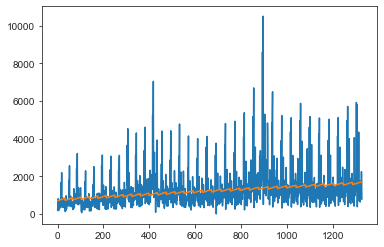

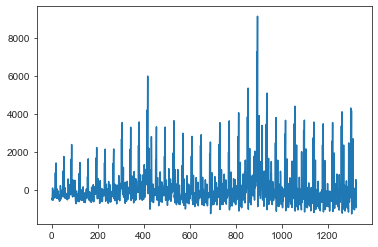

<function statsmodels.tools.eval_measures.rmse(x1, x2, axis=0)>

In [251]:
from pandas import datetime
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy
 
#Detrending the data through a linear regressor
 
series = test_df7

X=sales_train_df7[['shop_id','uniq_date']]
y=np.array(sales_train_df7['item_cnt_day_total'])
#x1=test_df6[['shop_id','uniq_date']]
model_lin = LinearRegression()
model_lin.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
pyplot.plot(y)
pyplot.plot(trend)
pyplot.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
pyplot.plot(detrended)
pyplot.show()

rmse

In [255]:


def mae(real,pred):
    result=np.mean(abs((real-pred)))
    return result    

RMSE_Lin=np.sqrt(mae(test_df6['shop_id'],model_lin))

real=test_df6[['shop_id','item_id']][test_df6['shop_id'].isin(list(pred_final.keys()))]

rmse_vec=[]

for k in pred_final.keys():
    rmse_vec.append(np.sqrt(mae(real['item_id'][real['shop_id']==k],pred_final[k])))
     

print('RMSE_Tree',RMSE_Tree)


RMSE_Tree 40.326421345536545


In [262]:
#  the OLS with DIFF technic still underfitted

test_df7['diffS']=test_df7['item_cnt_day_total'].diff()
test_df7['diffM']=test_df7['shop_id'].diff()

model3=sm.OLS(endog=test_df7['diffS'].dropna(),exog=test_df7[['diffM','uniq_date']].dropna())
results3=model3.fit()
print(results3.summary())


                                 OLS Regression Results                                
Dep. Variable:                  diffS   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.001
Method:                 Least Squares   F-statistic:                            0.07960
Date:                Mon, 09 Dec 2019   Prob (F-statistic):                       0.923
Time:                        02:05:30   Log-Likelihood:                         -11329.
No. Observations:                1325   AIC:                                  2.266e+04
Df Residuals:                    1323   BIC:                                  2.267e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\benia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\benia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [258]:
# the model is underfitted!



In [259]:
test_df7['lag']=test_df7['diffS'].shift()
test_df7.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=test_df7['item_cnt_day_total'],exog=test_df7[['lag']],order=[5,1,0])
results3=model3.fit()
print(results3.summary())

KeyError: 'diffS'